<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/09_vision_augment_experiments_profile_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
#colab
%%bash
pip install fastai2 --upgrade

In [3]:
#colab
%%bash
pip install git+https://github.com/butchland/fastai_xla_extensions

  Cloning https://github.com/butchland/fastai_xla_extensions to /tmp/pip-req-build-b5p6efdg
  Created wheel for fastai-xla-extensions: filename=fastai_xla_extensions-0.0.1-cp36-none-any.whl size=10373 sha256=1e71f25b4d9994ad4c9d4c6c4c48bb2a90616b328a267ed42782f2fa990dde0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5vhmsr9g/wheels/3c/d5/c1/7a96c15b4e74b5d1ec0bc6c29fcaf36501791ce2d9a88a8cea
Successfully built fastai-xla-extensions


  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-b5p6efdg


In [4]:
#colab
%%bash
pip install git+https://github.com/butchland/my_timesaver_utils

  Cloning https://github.com/butchland/my_timesaver_utils to /tmp/pip-req-build-wc7ixc2v
  Created wheel for my-timesaver-utils: filename=my_timesaver_utils-0.0.1-cp36-none-any.whl size=9098 sha256=6c08e6da56eb40d0857f431b86455b94073f2f7d431a327dfcee077f90f13b16
  Stored in directory: /tmp/pip-ephem-wheel-cache-y8vrqldl/wheels/ca/6d/f4/ad01bd19bc4c102a3851d9c636dc2a2031d97b98cb9a73effa
Successfully built my-timesaver-utils


  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-wc7ixc2v


In [ ]:
#colab
# install pytorch xla
# VERSION = "20200707"  #@param ["1.5" , "20200516","20200707", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [5]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

KeyError: ignored

In [6]:
%%bash
pip freeze | grep torch
pip freeze | grep fastai2

torch==1.6.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.7.0+cu101
fastai2==0.0.21


In [7]:
import fastai_xla_extensions.core

In [8]:
from fastai2.vision.all import *

In [9]:
from my_timesaver_utils.profiling import *

In [10]:
path = untar_data(URLs.PETS)/'images'

In [11]:
Path.BASE_PATH = path; path.ls()

(#7393) [Path('Maine_Coon_28.jpg'),Path('newfoundland_72.jpg'),Path('Maine_Coon_54.jpg'),Path('scottish_terrier_161.jpg'),Path('basset_hound_182.jpg'),Path('newfoundland_19.jpg'),Path('Maine_Coon_170.jpg'),Path('newfoundland_51.jpg'),Path('basset_hound_158.jpg'),Path('Birman_46.jpg')...]

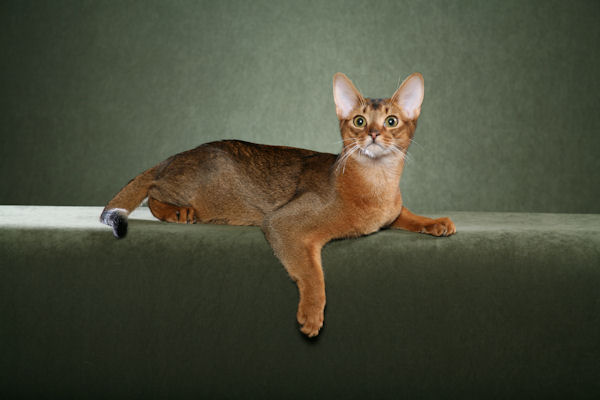

In [12]:
img = PILImage.create(path/'Abyssinian_1.jpg');img

In [13]:
img.shape

(400, 600)

In [14]:
resize = Resize(size=200)

In [15]:
img2 = resize(img,split_idx=0)
img2.shape

(200, 200)

In [16]:
timg2 = TensorImage(array(img2)).permute(2,0,1).float()/255.; timg2.shape

torch.Size([3, 200, 200])

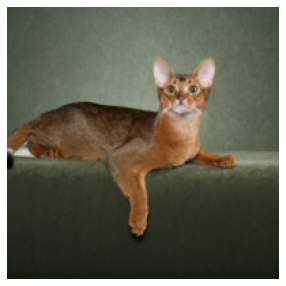

In [17]:
show_image(timg2)

In [18]:
default_device()

device(type='cuda', index=0)

In [19]:
torch.cuda.is_available()

True

In [20]:
def batch_ex(bs, device): return TensorImage(timg2[None].to(device).expand(bs, *timg2.shape))

In [21]:
b768_img = batch_ex(768, default_device()); (b768_img.shape, b768_img.device)

(torch.Size([768, 3, 200, 200]), device(type='cuda', index=0))

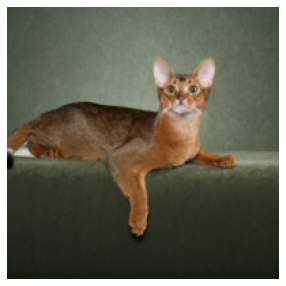

In [22]:
show_image(b768_img[-1].to(torch.device('cpu')));

### Add transform

In [23]:
flip_tfm = Flip(p=1.0); flip_tfm

AffineCoordTfm:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: 

### Add profilers 

In [24]:
F.grid_sample = profile_call(F.grid_sample)

In [25]:
@profile_call
def mtest(b_img):
    #set_trace()
    new_b_img = flip_tfm(b_img)
    return new_b_img

### Profile transform calls

In [26]:
clear_prof_data()

In [27]:
%%time
new_b768_img = mtest(b768_img)

CPU times: user 15.8 ms, sys: 10.4 ms, total: 26.2 ms
Wall time: 252 ms


In [28]:
print_prof_data()

Function grid_sample called 1 times.
Execution time max: 0.003, average: 0.003
Function mtest called 1 times.
Execution time max: 0.252, average: 0.252


In [29]:
(new_b768_img.shape, new_b768_img.device)

(torch.Size([768, 3, 200, 200]), device(type='cuda', index=0))

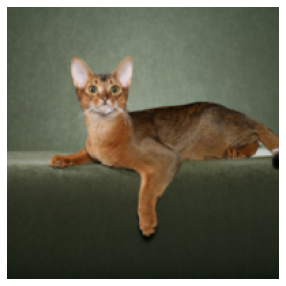

In [30]:
show_image(new_b768_img[-1].to(torch.device('cpu')));

In [31]:
clear_prof_data()

In [32]:
%%time
for i in range(10): new_b768_img = mtest(b768_img)

CPU times: user 132 ms, sys: 69.5 ms, total: 201 ms
Wall time: 205 ms


In [33]:
print_prof_data()

Function grid_sample called 10 times.
Execution time max: 0.000, average: 0.000
Function mtest called 10 times.
Execution time max: 0.021, average: 0.020
